In [1]:
from witch.core import model
from witch.utils import *
from witch.fitter import *
from witch.containers import Model
import witch.mapmaking as mm

import minkasi.tools.presets_by_source as pbs
import minkasi

from astropy.coordinates import Angle
import astropy.units as units

import yaml
import numpy as np
import os
import glob
import shutil

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

mpi4py imported
nproc:,  1


In [2]:

#path = "/home/jorlo/dev/minkasi_jax/configs/MOOJ1142/MOOJ1142_SHOCK.yaml"
path = "/home/jorlo/dev/minkasi_jax/unit_tests/cyl_unit.yaml"
with open(path, "r") as file:
    cfg = yaml.safe_load(file)
if "models" not in cfg:
    cfg["models"] = {}
fit = True

In [3]:
cfg = load_config({}, path)
cfg["fit"] = cfg.get("fit", "model" in cfg)
cfg["sim"] = cfg.get("sim", False)
cfg["wnoise"] = cfg.get("wnoise", False)
cfg["map"] = cfg.get("map", True)
cfg["sub"] = cfg.get("sub", True)

cfg["sim"] = False

In [4]:
todroot = cfg["paths"]["tods"]
if not os.path.isabs(todroot):
    todroot = os.path.join(
        os.environ.get("MJ_TODROOT", os.environ["HOME"]), todroot
    )
tod_names = glob.glob(os.path.join(todroot, cfg["paths"]["glob"]))
bad_tod, _ = pbs.get_bad_tods(
    cfg["name"], ndo=cfg["paths"]["ndo"], odo=cfg["paths"]["odo"]
)
if "cut" in cfg["paths"]:
    bad_tod += cfg["paths"]["cut"]
tod_names = minkasi.tods.io.cut_blacklist(tod_names, bad_tod)
tod_names.sort()
ntods = cfg["minkasi"].get("ntods", None)
tod_names = tod_names[:ntods]
tod_names = tod_names[minkasi.myrank :: minkasi.nproc]
minkasi.barrier()  # Is this needed?

todvec = minkasi.tods.TodVec()
ntods = 60
for i, fname in enumerate(tod_names):
    if i > ntods: break
    dat = minkasi.tods.io.read_tod_from_fits(fname)
    minkasi.tods.processing.truncate_tod(dat)
    minkasi.tods.processing.downsample_tod(dat)
    minkasi.tods.processing.truncate_tod(dat)
    # figure out a guess at common mode and (assumed) linear detector drifts/offset
    # drifts/offsets are removed, which is important for mode finding.  CM is *not* removed.
    dd, pred2, cm = minkasi.tods.processing.fit_cm_plus_poly(
        dat["dat_calib"], cm_ord=3, full_out=True
    )
    dat["dat_calib"] = dd
    dat["pred2"] = pred2
    dat["cm"] = cm

    tod = minkasi.tods.Tod(dat)
    todvec.add_tod(tod)

deleted  0  bad files.
WARNING - calinfo information not found in fits file header - to track JytoK etc you may need to reprocess the fits files using mustangidl > revision 932
ndata and ndet are  72 23691 72  on  /mnt/welch/MUSTANG/M2-TODs/RXJ1347/Signal_TOD-AGBT16A_473_02-s134.fits with lims  206.7930066322188 206.9415359259099 -11.834223958811396 -11.67501907944757
truncating from  23691  to  23626
truncating from  2362  to  2353
WARNING - calinfo information not found in fits file header - to track JytoK etc you may need to reprocess the fits files using mustangidl > revision 932
ndata and ndet are  76 9219 76  on  /mnt/welch/MUSTANG/M2-TODs/RXJ1347/Signal_TOD-AGBT16A_473_02-s135.fits with lims  206.79441365118782 206.9250205284968 -11.828844331066366 -11.675085673791976
truncating from  9219  to  9217
truncating from  921  to  901
WARNING - calinfo information not found in fits file header - to track JytoK etc you may need to reprocess the fits files using mustangidl > revision 93

In [5]:
lims = todvec.lims()
pixsize = 2.0 / 3600 * np.pi / 180
skymap = minkasi.maps.SkyMap(lims, pixsize)


model = Model.from_cfg(cfg)
funs = [model.minkasi_helper]
params = np.array(model.pars)
npars = np.array([len(params)])
prior_vals = model.priors
priors = [None if prior is None else "flat" for prior in prior_vals]

# Deal with bowling and simming in TODs and setup noise
noise_class = eval(str(cfg["minkasi"]["noise"]["class"]))
noise_args = eval(str(cfg["minkasi"]["noise"]["args"]))
noise_kwargs = eval(str(cfg["minkasi"]["noise"]["kwargs"]))
bowl_str = process_tods(
    cfg, todvec, skymap, noise_class, noise_args, noise_kwargs, model
)

# Get output
outdir = get_outdir(cfg, bowl_str, model)

got svd
got svd
got svd
got svd
got svd
got svd
got svd
got svd
got svd
got svd
got svd
got svd
Outputs can be found in /mnt/welch/USERS/jorlo/Reductions/SIM/cyl/


In [6]:
# Make maps
npass = cfg["minkasi"]["npass"]
dograd = cfg["minkasi"]["dograd"]
# get the hit count map.  We use this as a preconditioner
# which helps small-scale convergence quite a bit.
hits = minkasi.mapmaking.make_hits(todvec, skymap)
naive = skymap.copy()
naive.clear()
for tod in todvec.tods:
    tmp = tod.info["dat_calib"].copy()
    u, s, v = np.linalg.svd(tmp, 0)
    pred = np.outer(u[:, 0], s[0] * v[0, :])
    tmp = tmp - pred
    naive.tod2map(tod, tmp)
naive.mpi_reduce()
naive.map[hits.map > 0] = naive.map[hits.map > 0] / hits.map[hits.map > 0]
if minkasi.myrank == 0:
    naive.write(os.path.join(outdir, "naive.fits"))
    hits.write(os.path.join(outdir, "hits.fits"))
hits_org = hits.copy()
hits.invert()

# setup the mapset.  In general this can have many things
# in addition to map(s) of the sky, but for now we'll just
# use a single skymap.
weightmap = minkasi.mapmaking.make_hits(todvec, skymap, do_weights=True)
mask = weightmap.map > 0
tmp = weightmap.map.copy()
tmp[mask] = 1.0 / np.sqrt(tmp[mask])
noisemap = weightmap.copy()
noisemap.map[:] = tmp
if minkasi.myrank == 0:
    noisemap.write(os.path.join(outdir, "noise.fits"))
    weightmap.write(os.path.join(outdir, "weights.fits"))

mapset = minkasi.maps.Mapset()
mapset.add_map(skymap)

# make A^T N^1 d.  TODs need to understand what to do with maps
# but maps don't necessarily need to understand what to do with TODs,
# hence putting make_rhs in the vector of TODs.
# Again, make_rhs is MPI-aware, so this should do the right thing
# if you run with many processes.
rhs = mapset.copy()
todvec.make_rhs(rhs)

# this is our starting guess.  Default to starting at 0,
# but you could start with a better guess if you have one.
x0 = rhs.copy()
x0.clear()

# preconditioner is 1/ hit count map.  helps a lot for
# convergence.
precon = mapset.copy()
precon.maps[0].map[:] = hits.map[:]

In [7]:
# run PCG

iters = [5, 25, 50]
mapset_out = minkasi.mapmaking.run_pcg_wprior(
    rhs,
    x0,
    todvec,
    None,
    precon,
    maxiter=50,
    outroot=os.path.join(outdir, "noprior"),
    save_iters=iters,
)


[0.00597501 0.03966165 0.00507951]
0 4127761094.7500315 0.05297040939331055
[0.00591588 0.03943658 0.00513315]
1 442826303.2921652 1.382396819301049e-05 0.05104780197143555 0.0016384124755859375 0.052686214447021484 71.4313811599645
[0.0060029  0.04009867 0.00502682]
2 124873972.73146859 8.006706332718677e-06 0.05171942710876465 0.0015363693237304688 0.05325579643249512 70.50377786149258
[0.00603104 0.03980231 0.00507903]
3 56417936.30920147 7.755084621084497e-06 0.051484107971191406 0.0016236305236816406 0.05310773849487305 70.8260304721682
[0.00597906 0.04002237 0.00509715]
4 28137646.11992388 5.34576843717103e-06 0.05165672302246094 0.0016510486602783203 0.05330777168273926 70.58935965439575
[0.00598001 0.03974509 0.00506496]
5 10682997.182697568 7.43599134966059e-06 0.05135488510131836 0.001623392105102539 0.0529782772064209 71.00424804390013
[0.00610709 0.040061   0.00505185]
6 5310204.669399121 9.849021921211403e-06 0.05184817314147949 0.0015857219696044922 0.053433895111083984 7

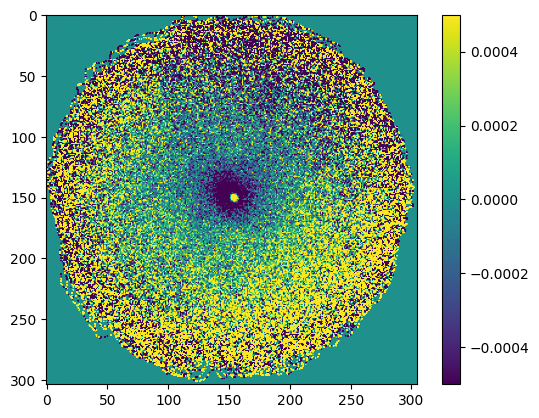

-0.009185566604568268


In [8]:

cur_map = mapset_out.maps[0].map#naive.map #

lim = 5e-4
plt.imshow(cur_map, vmin = -lim, vmax = lim)
plt.colorbar()
plt.show()
print(np.amin(cur_map[200:300, 150:250]))


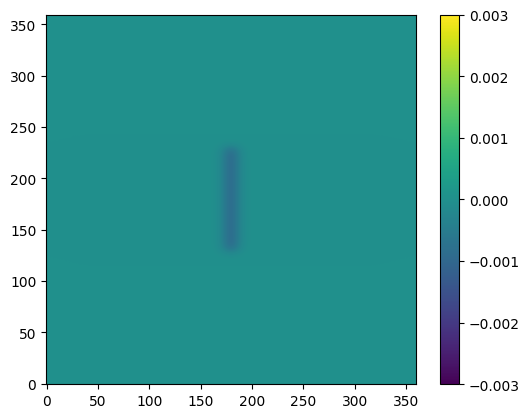

In [9]:
vis_model = model.model
lim = 3e-3

plt.imshow(vis_model, vmin = -lim, vmax = lim, origin="lower")
plt.colorbar()
plt.show()

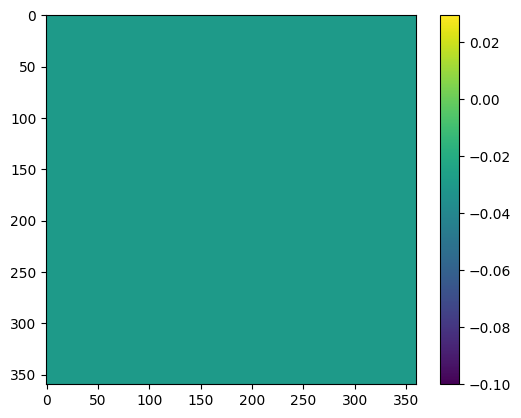

In [10]:
from witch.core import stage2_model

vis_model = stage2_model(model.xyz, 
                   tuple(model.n_struct),
                   model.dz,
                   model.beam,
                   *model.pars,
        )
lim = np.amin(vis_model)

plt.imshow(vis_model, vmin = -lim, vmax = 0)
plt.colorbar()
plt.show()